<a href="https://colab.research.google.com/github/HromovAndrey/II_Homework_mood_6_part_2/blob/main/%D0%94%D0%97_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install torch==2.0.1 torchtext==0.15.2

In [52]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torchtext

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [54]:
df = pd.read_csv("/content/archive (4).zip")
print(df.columns)

Index(['text_type', 'text'], dtype='object')


In [55]:
df = df[['text', 'text_type']]
df = df.rename(columns={'text_type': 'labels', 'text': 'data'})

In [56]:
class MyDataset(Dataset):
    def __init__(self, X, y, max_len=100):
        self.X = X
        self.y = y
        self.max_len = max_len

        self.label_encoder = LabelEncoder().fit(y)
        self.vocab = torchtext.vocab.GloVe(name='6B', dim=50)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        label = self.label_encoder.transform([self.y.iloc[idx]])
        label = torch.tensor(label, dtype=torch.long)  # Используем long для совместимости с CrossEntropyLoss

        text = self.X.iloc[idx]
        tokens = text.split()

        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            diff = self.max_len - len(tokens)
            tokens += [''] * diff

        X = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)

        return X, label[0]



dataset = MyDataset(df['data'], df['labels'])



In [57]:
dataset[0][0].shape

torch.Size([100, 50])

In [58]:
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

In [59]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [60]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)



In [61]:
class TextClassifier(nn.Module):
    def __init__(self, encoding_dim, max_len, num_classes):
        super().__init__()
        self.pos_encoder = PositionalEncoding(d_model=encoding_dim, max_len=max_len)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=encoding_dim, nhead=2, batch_first=True, dim_feedforward=64),
            num_layers=1
        )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(encoding_dim * max_len, num_classes)

    def forward(self, x):
        out = self.pos_encoder(x)
        out = self.encoder(out)
        out = self.flatten(out)
        out = self.linear1(out)
        return out
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            outputs = self(X.float())
            probabilities = F.softmax(outputs, dim=-1)
        return probabilities.cpu().numpy()



In [62]:
num_classes = len(df['labels'].unique())
model = TextClassifier(encoding_dim=50, max_len=100, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
def train(model, optimizer, criterion, train_loader, test_loader, epochs=10, device='cpu'):
    history = {'loss': [], 'val_loss': [], 'accuracy_score': [], 'val_accuracy_score': []}
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        val_accuracy = evaluate_model(test_loader, model)
        val_loss = compute_loss(test_loader, model, criterion)

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy_score'].append(train_accuracy)
        history['val_accuracy_score'].append(val_accuracy)

        print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return history

In [64]:
def compute_loss(loader, model, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts.float())
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

In [65]:
def evaluate_model(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts.float())
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [66]:
history = train(model, optimizer, criterion, train_loader, test_loader, epochs=10, device=device)

Epoch 1, Loss: 0.4037, Val Loss: 0.2725, Train Accuracy: 0.8230, Val Accuracy: 0.8919
Epoch 2, Loss: 0.2941, Val Loss: 0.2758, Train Accuracy: 0.8802, Val Accuracy: 0.8872
Epoch 3, Loss: 0.2659, Val Loss: 0.2678, Train Accuracy: 0.8889, Val Accuracy: 0.8823
Epoch 4, Loss: 0.2388, Val Loss: 0.2334, Train Accuracy: 0.9039, Val Accuracy: 0.9135
Epoch 5, Loss: 0.2285, Val Loss: 0.2114, Train Accuracy: 0.9066, Val Accuracy: 0.9204
Epoch 6, Loss: 0.2069, Val Loss: 0.2019, Train Accuracy: 0.9163, Val Accuracy: 0.9199
Epoch 7, Loss: 0.1957, Val Loss: 0.2209, Train Accuracy: 0.9197, Val Accuracy: 0.9170
Epoch 8, Loss: 0.1891, Val Loss: 0.1987, Train Accuracy: 0.9219, Val Accuracy: 0.9236
Epoch 9, Loss: 0.1823, Val Loss: 0.1834, Train Accuracy: 0.9235, Val Accuracy: 0.9285
Epoch 10, Loss: 0.1716, Val Loss: 0.2451, Train Accuracy: 0.9277, Val Accuracy: 0.9108


In [67]:
def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_' + name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
    plt.show()

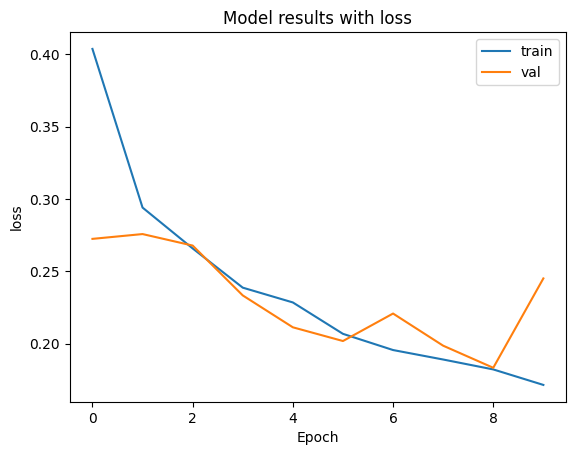

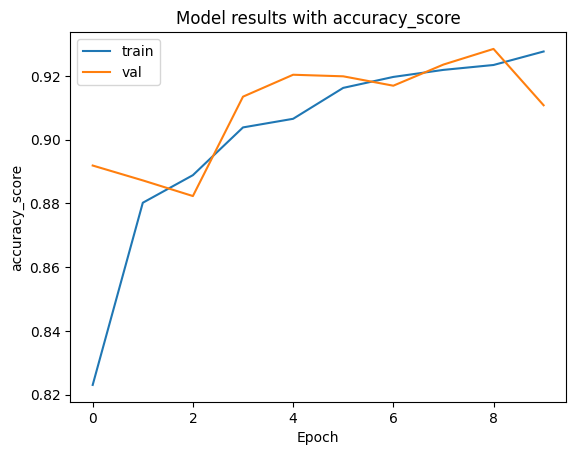

In [68]:
plot_metric(history, 'loss')
plot_metric(history, 'accuracy_score')

In [69]:
model = model.to('cpu')
loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))
y_pred = model.predict(X_test)

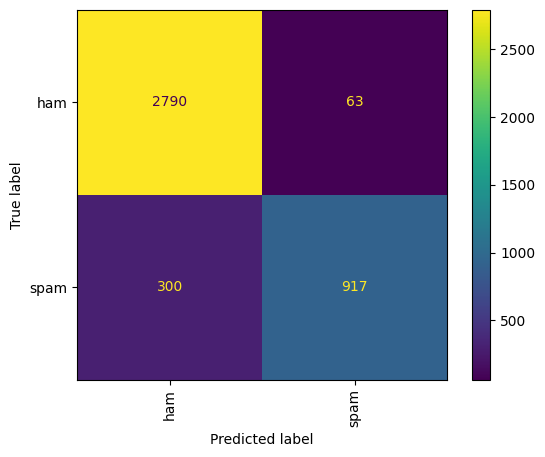

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset.label_encoder.classes_)
plt.xticks(rotation=90)
plt.show()